In [3]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

In [4]:
# 加载数据
data = pd.read_csv('diabetes.csv')
print('dataset ahape {}'.format(data.shape))
data.head()

dataset ahape (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
data.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

In [6]:
#iloc是基于索引位来选取数据集，0:4就是选取 0，1，2，3这四行，需要注意的是这里是前闭后开集合
# 使用 iloc 进行行列混合选择 
#data.iloc[0:5] 数据中的第 1-5 行 
# data.iloc[:, 0:2]  选择数据中的前2列和所有行 
# data.iloc[[0, 3, 6, 24], [0, 5, 6]] 选择第 1,4,7,25行 和 第 1,6,7 列 
# data.iloc[0:5, 5:8]  #选择第1-6行 和 6-9列
# 含有特征的数据集
X = data.iloc[:,0:8]
# 标记数据
Y = data.iloc[:,8]
print('shape of X {} ; shape of Y {}'.format(X.shape,Y.shape))
print(X)
print(Y)

shape of X (768, 8) ; shape of Y (768,)
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
5              5      116             74              0        0  25.6   
6              3       78             50             32       88  31.0   
7             10      115              0              0        0  35.3   
8              2      197             70             45      543  30.5   
9              8      125             96              0        0   0.0   
10             4      110             92              0        0  37.6   
11            10      168             74              0        0  38.0  

In [7]:
from sklearn.model_selection import train_test_split
# 将数据集划分为训练集和测试集，其中测试数据为20%
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)

In [8]:
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
#我们使用三种算法对数据进行拟合即普通的k-均值算法，带权重的k-均值算法和指定半径的k-均值算法。
#models.append方法就是将一个元素放入models列表中
models = []
models.append(('KNN',KNeighborsClassifier(n_neighbors=7)))
models.append(('KNN with weights',KNeighborsClassifier(n_neighbors=7,weights='distance')))
models.append(('Radius Neighbors',RadiusNeighborsClassifier(n_neighbors=7,radius=500.0)))
models

[('KNN',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=7, p=2,
             weights='uniform')),
 ('KNN with weights',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=7, p=2,
             weights='distance')),
 ('Radius Neighbors',
  RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
               metric_params=None, n_jobs=None, outlier_label=None, p=2,
               radius=500.0, weights='uniform'))]

In [9]:
results = []
for name,model in models:
    #fit(x,y)传两个参数的是有监督学习的算法，fit(x)传一个参数的是无监督学习的算法，比如降维、特征提取、标准化
    model.fit(X_train,Y_train)
    results.append((name,model.score(X_test,Y_test)))
for i in range(len(results)):
    print('name:{}; score: {}'.format(results[i][0],results[i][1]))

name:KNN; score: 0.6948051948051948
name:KNN with weights; score: 0.6883116883116883
name:Radius Neighbors; score: 0.6428571428571429


In [10]:
#kfold 将数据分成10份，其中一份作为交叉验证数据集来计算模型准确性。
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# 因为训练样本和测试样本是随机的，
# 所以我们需要多次分配训练集和交叉验证数据集，然后对多次预测结果进行平均。
results = []
for name,model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model,X,Y,cv=kfold)
    results.append((name,cv_result))
for i in range(len(results)):
    print('name: {}; cross val score: {}'.format
          (results[i][0],results[i][1].mean()))





name: KNN; cross val score: 0.7448051948051948
name: KNN with weights; cross val score: 0.7396103896103897
name: Radius Neighbors; cross val score: 0.6497265892002735


## 模型训练

In [11]:
knn = KNeighborsClassifier(n_neighbors=5,weights='distance')
knn.fit(X_train,Y_train)
train_score = knn.score(X_train,Y_train)
test_score = knn.score(X_test,Y_test)
print('train score: {} ; test score: {}'.format(train_score, test_score))


train score: 1.0 ; test score: 0.6883116883116883


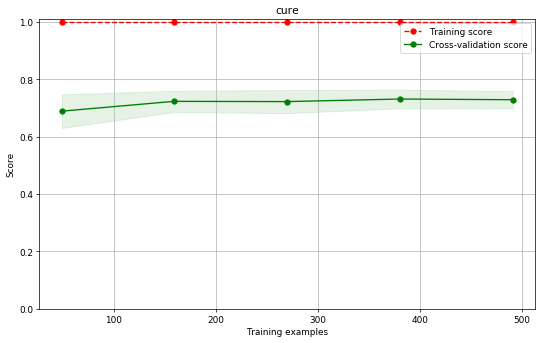

In [12]:
from sklearn.model_selection import ShuffleSplit  
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
x = X_train
y = Y_train
#画出data在某模型上的learning curve.
def plot_learning_curve(plt, estimator, title, X, y ,ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.1,1.0,5)):
#参数解释
    #estimator : 你用的分类器。
    #title : 表格的标题。
    #x: 输入的feature，numpy类型
    #y : 输入的target vector
    #ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    #cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，
    #其余n-1份作为training(默认为3份)    
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
    estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,
                    train_scores_mean + train_scores_std,alpha = 0.1, color='r')
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o--', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

cv=ShuffleSplit(n_splits=10,test_size=0.2,random_state=0) # 打乱数据，取几折防止数据有序
plt.figure(figsize=(10,6),dpi=64)
plot_learning_curve(plt,knn,"cure",x,y,ylim=(0.0,1.01),cv=cv)
plt.show()
    
    

## 数据可视化

In [20]:
from sklearn.feature_selection import SelectKBest
X = x
Y = y
selector = SelectKBest(k=3)# 影响最大的两项
X_new = selector.fit_transform(X,Y)
X_new[0:9]
# 用SelectKBest筛选特征后怎么知道选出来的是哪些特征 
# 查看,影响最大的项,为True
# selector.get_support()

array([[148. ,  37.6,  51. ],
       [112. ,  39.4,  24. ],
       [193. ,  25.9,  24. ],
       [155. ,  34. ,  46. ],
       [107. ,  28.3,  29. ],
       [180. ,  43.3,  41. ],
       [194. ,  26.1,  67. ],
       [155. ,  33.3,  51. ],
       [171. ,  33.3,  24. ]])

In [55]:
results = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_result = cross_val_score(model,X_new, Y, cv=kfold)
    results.append((name,cv_result))
for i in range(len(results)):
    print('name: {}; cross val score: {}'.format(results[i][0],results[i][1].mean()))
    

name: KNN; cross val score: 0.7099947117927023
name: KNN with weights; cross val score: 0.703437334743522
name: Radius Neighbors; cross val score: 0.6608937070333156


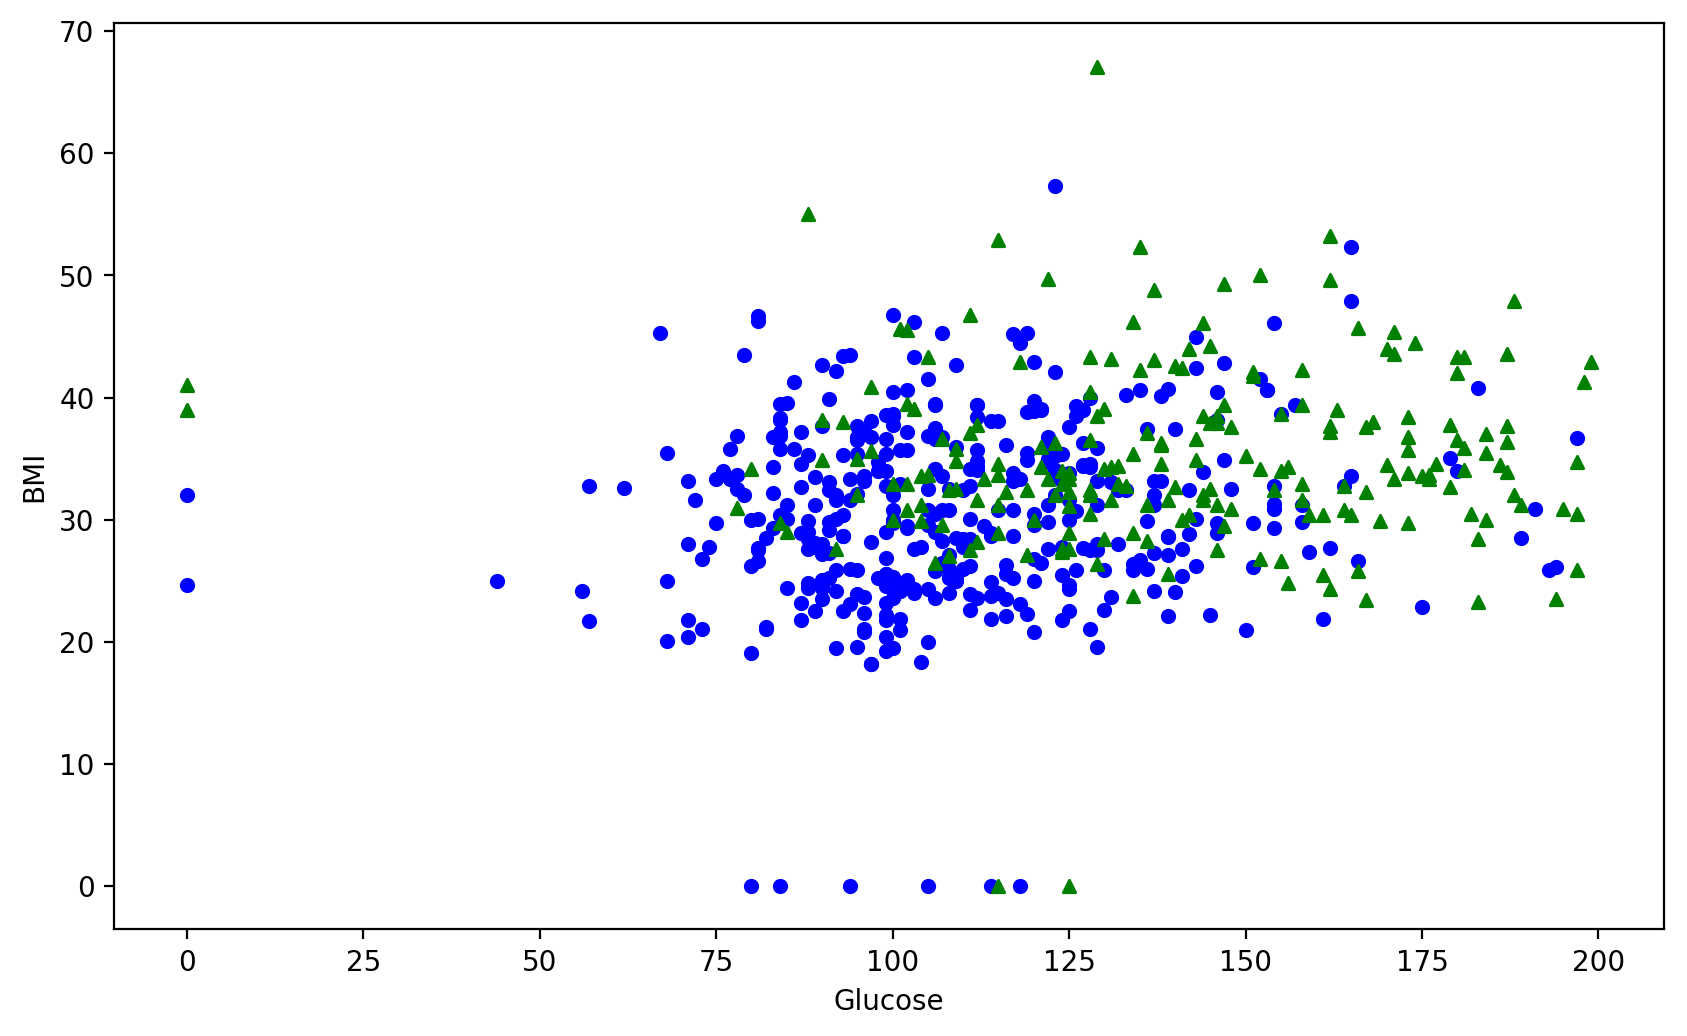

In [52]:
# 画出数据报
plt.figure(figsize=(10,6),dpi=200)
plt.ylabel('BMI')
plt.xlabel('Glucose')
plt.scatter(X_new[Y==0][:, 0], X_new[Y==0][:, 1], c='b', s=20, marker='o');         # 画出样本
plt.scatter(X_new[Y==1][:, 0], X_new[Y==1][:, 1], c='g', s=20, marker='^');         # 画出样本

In [45]:
X_new[Y==0][:,1]

array([ 92.,  84.,  78., 128.,  81.,  99.,  92., 111., 128.,  94.,  99.,
        75., 137., 116., 129., 130., 114., 111.,  87.,  99., 137., 123.,
        95.,  93., 157., 175., 126., 101., 129., 119.,  99., 125.,  88.,
       194.,  99., 162.,  57., 118.,  77.,  81., 105., 112., 151., 101.,
       125., 122., 120., 136., 123., 123., 189., 100., 108., 110., 122.,
       128.,  99., 106., 154.,  98., 113.,  99., 102.,  90., 119.,  91.,
       165., 120., 111., 101., 141.,  82., 112., 125., 107., 101., 197.,
        89., 145., 105., 191., 122., 144.,  82.,  99., 112., 112., 102.,
        83., 106., 153., 125., 105., 105., 143.,  95., 100., 164., 129.,
       107., 128.,  88., 114.,  89.,  90.,  81.,  87.,  99., 129.,  94.,
       115., 107.,  79., 139.,  95., 124.,  71., 114., 114.,  96.,  93.,
       111.,  97., 112., 100., 106., 134.,  97., 158., 117.,  95.,  84.,
       107.,  88.,   0., 147.,  72., 158., 120.,  84., 103.,  90.,  96.,
       123.,  91.,  95., 127., 139., 102., 116., 10